# Fetal lung fibroblast and smooth muscle

### Data source

https://cellxgene.cziscience.com/collections/2d2e2acd-dade-489f-a2da-6c11aa654028

### Environment setup

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
from scgraph import scGraph
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}
visual_cfg = {'frameon': False, 'legend_fontsize': 10, 'legend_fontoutline': 2}
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
proj_name = "fetal_lung_fibro_scgraph"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'mps'
seed = 0
ccd.ul.set_seed(seed)
file_suffix = f"{proj_name}_{time.strftime('%b%d-%H%M')}"
ccd.set_verbose_mode(True)
timer = ccd.ul.Timer()
time_log = {}

In [ ]:
data_dir = Path("../data/fetal_lung_fibro/")
adata = sc.read(
    data_dir / "577d363e-f548-4f0f-922e-e0beba0e86aa.h5ad"
)
batch_key = "batch"
state_key = 'new_celltype'
show_cols = ['batch', 'development_stage', 'new_celltype']
n_comps = 50
adata = adata.raw.to_adata()
adata.layers['counts'] = adata.X.copy()
adata


AnnData object with n_obs × n_vars = 39204 × 23693
    obs: 'batch', 'dissection', 'chemistry', 'percent_mito', 'n_counts', 'n_genes', 'leiden', 'phase', 'S_score', 'G2M_score', 'new_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'batch_colors', 'citation', 'default_embedding', 'rank_genes_groups', 'rank_genes_groups_filtered', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_C0filteredumap', 'X_C0umap', 'X_pca', 'X_umap'
    layers: 'counts'

In [78]:
# normalize and preprocess
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3", batch_key="batch")
adata = adata[:, adata.var.highly_variable].copy()

### No correction

In [ ]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

In [80]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_comps, use_rep="X_pca")
sc.tl.umap(adata, min_dist=0.1)

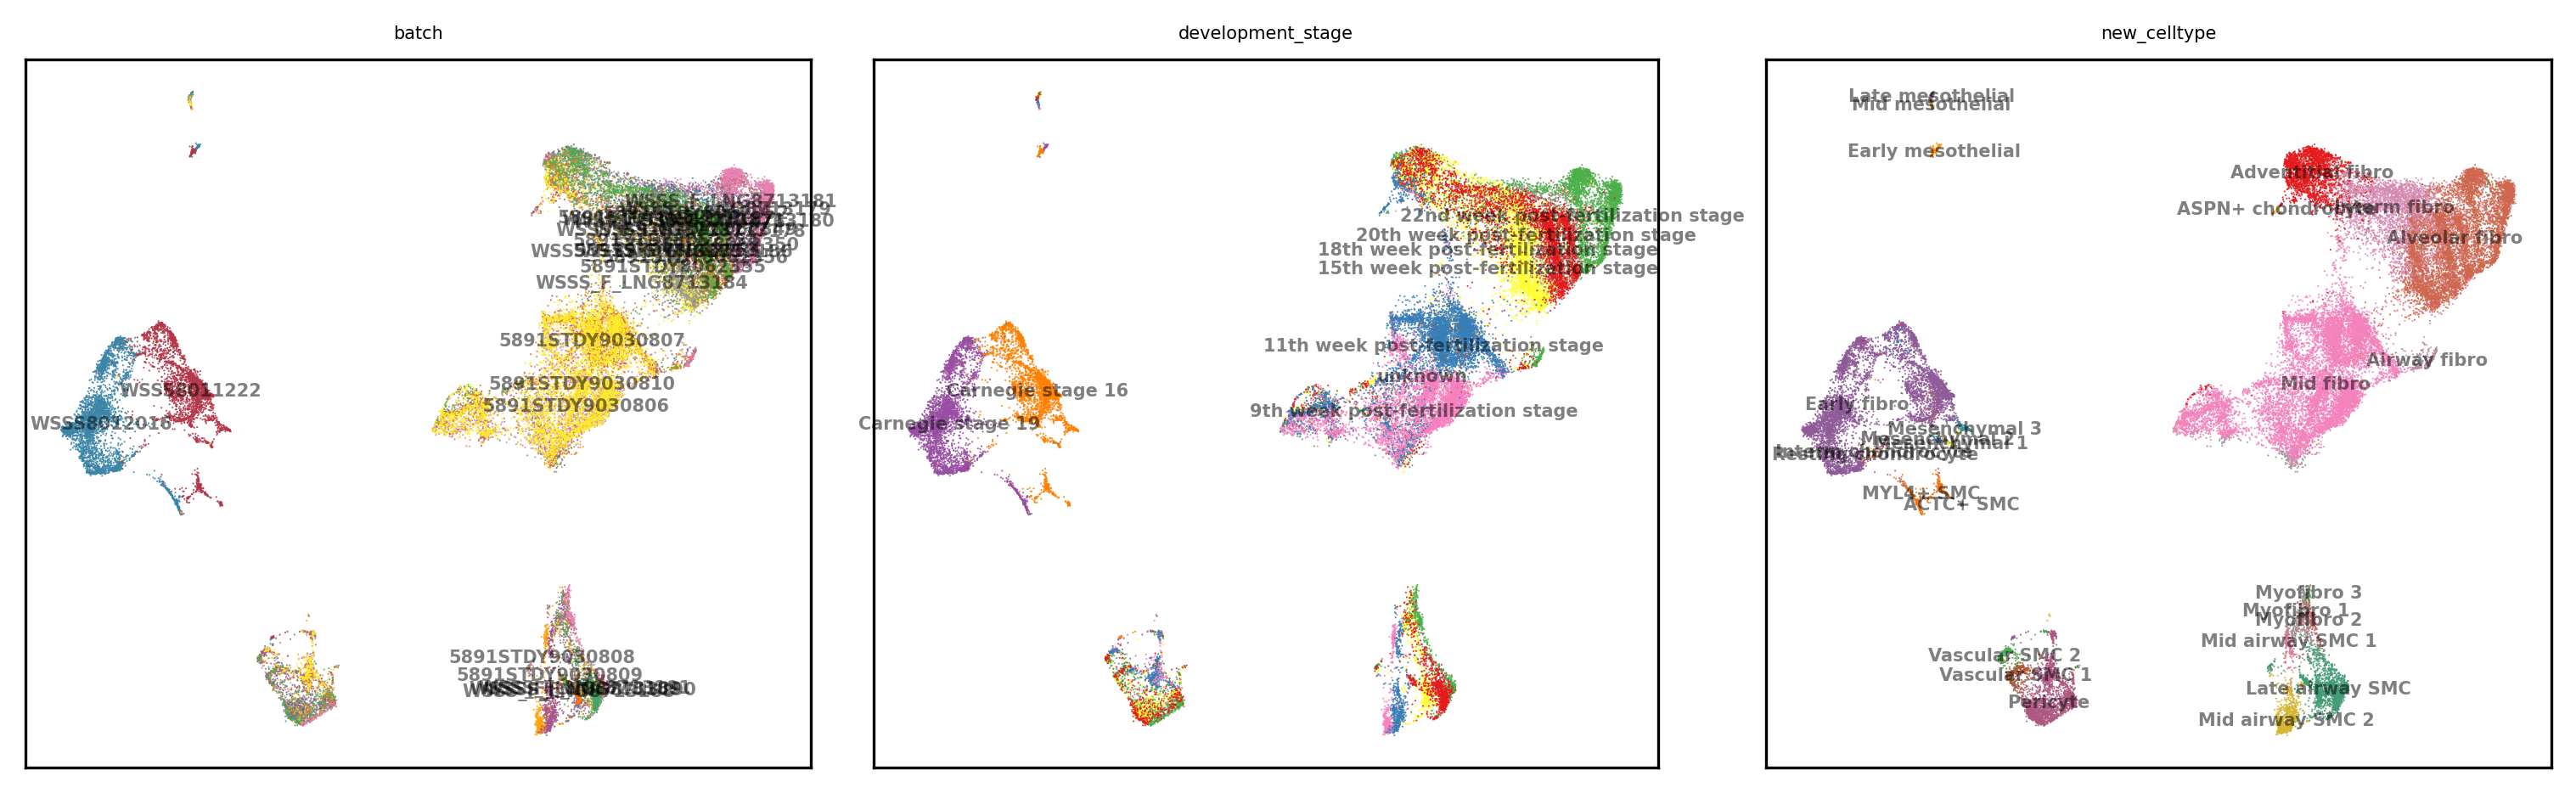

In [81]:
show_basis = 'X_umap'

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=1, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### Scanorama

In [82]:
output_key = 'Scanorama'

with timer:
    ccd.ul.run_scanorama(adata, batch_key=batch_key, output_key=output_key, dimred=n_comps, return_corrected=False)

time_log[output_key] = timer.interval

Found 2000 genes among all datasets
[[0.         0.00591716 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.      

Concord - INFO - UMAP embedding stored in adata.obsm['Scanorama_UMAP']


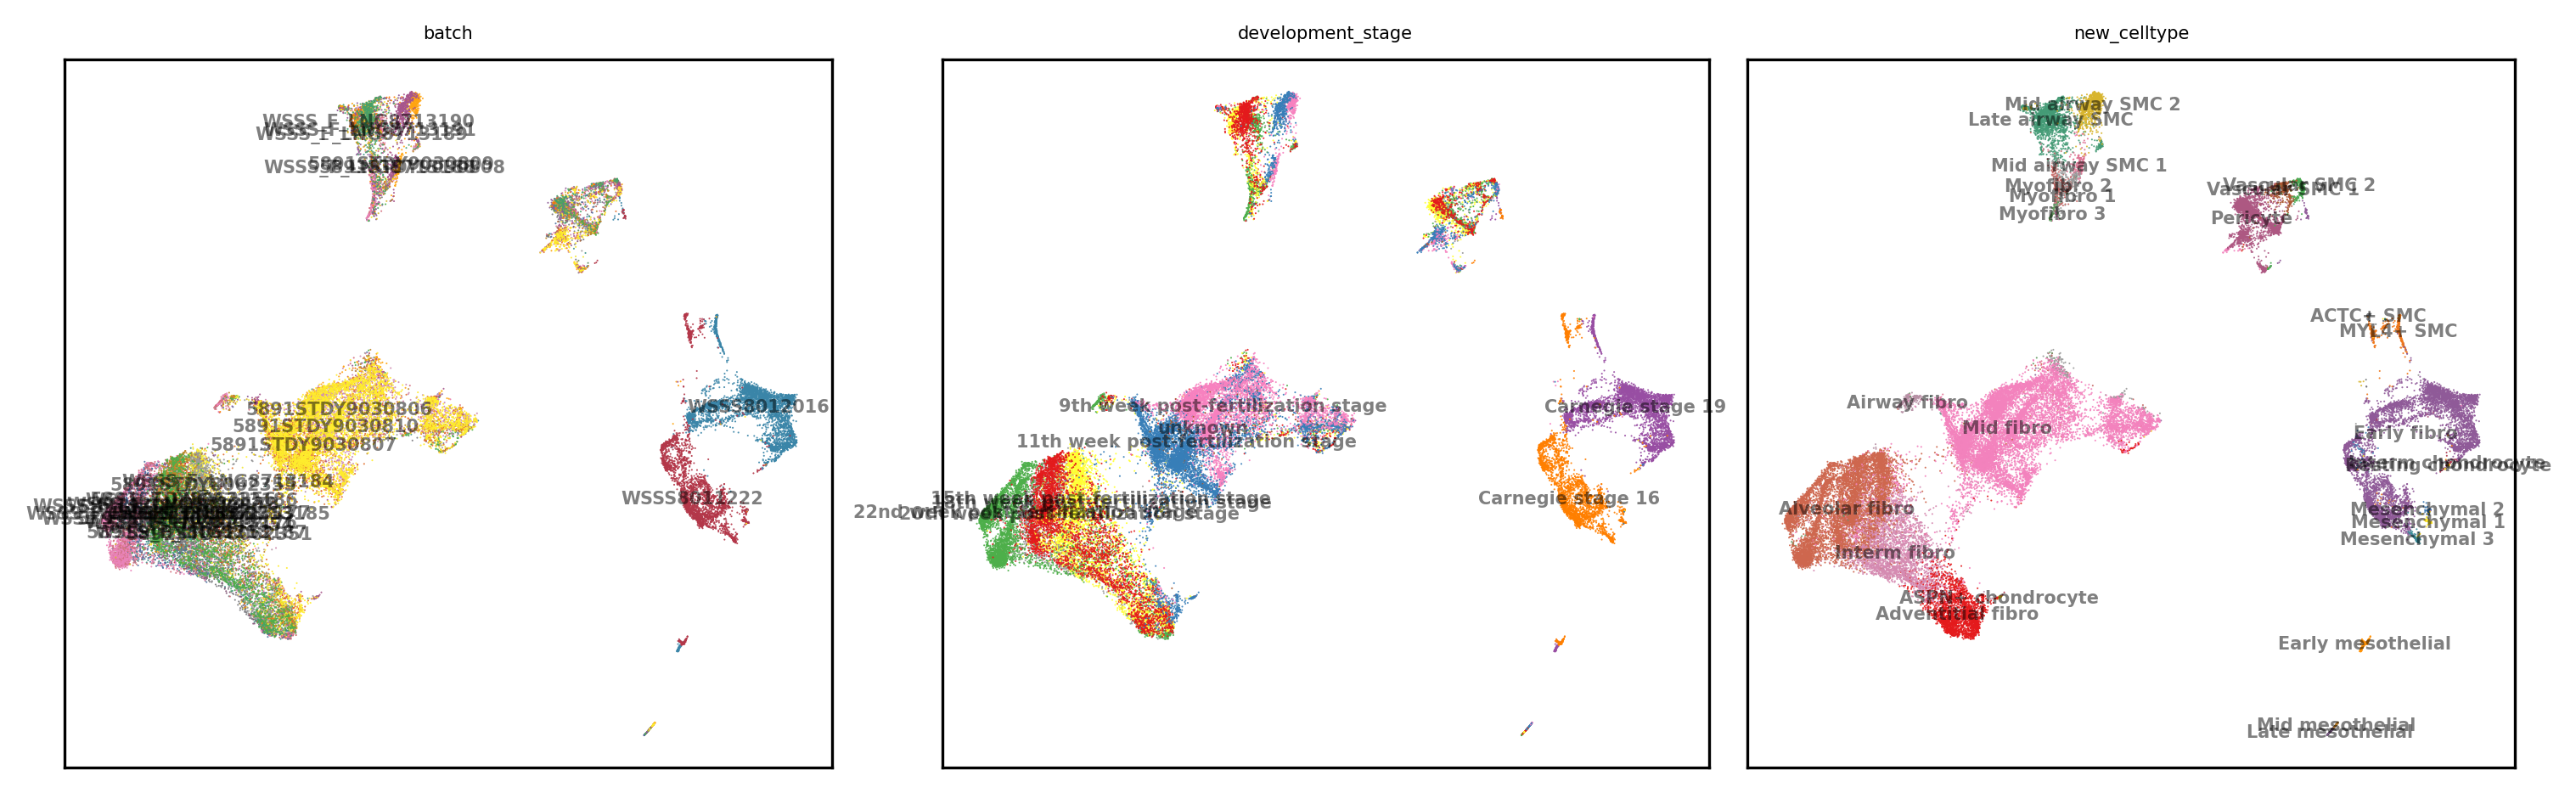

In [84]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=1, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### LIGER

In [ ]:
output_key = 'Liger'
with timer:
    ccd.ul.run_liger(adata, batch_key=batch_key, count_layer="counts", output_key=output_key, k=n_comps, return_corrected=False)
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

100%|██████████| 30/30 [07:49<00:00, 15.65s/it]


Concord - INFO - UMAP embedding stored in adata.obsm['Liger_UMAP']


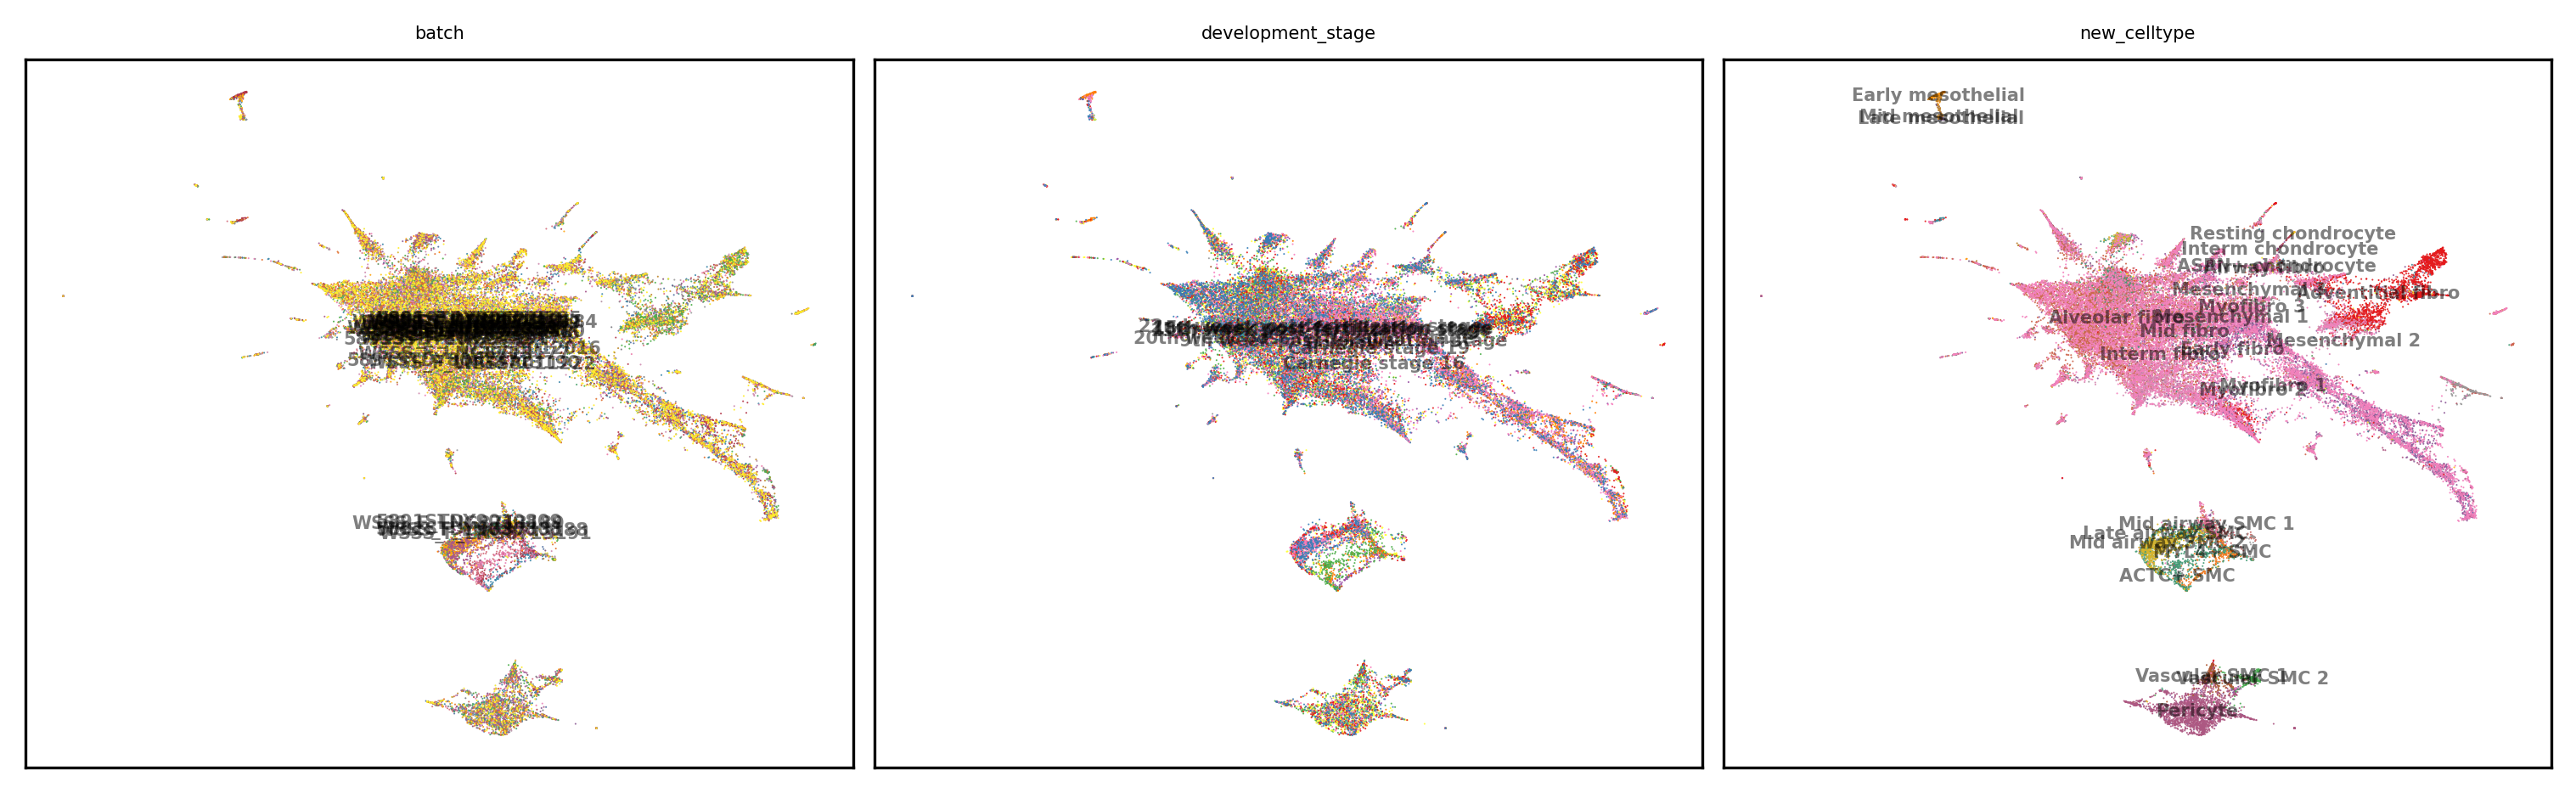

In [88]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=1, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### Harmony

In [100]:
output_key = 'Harmony'
with timer:
    ccd.ul.run_harmony(adata, batch_key=batch_key, input_key='X_pca', output_key=output_key, n_comps=n_comps)


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


Concord - INFO - UMAP embedding stored in adata.obsm['Harmony_UMAP']


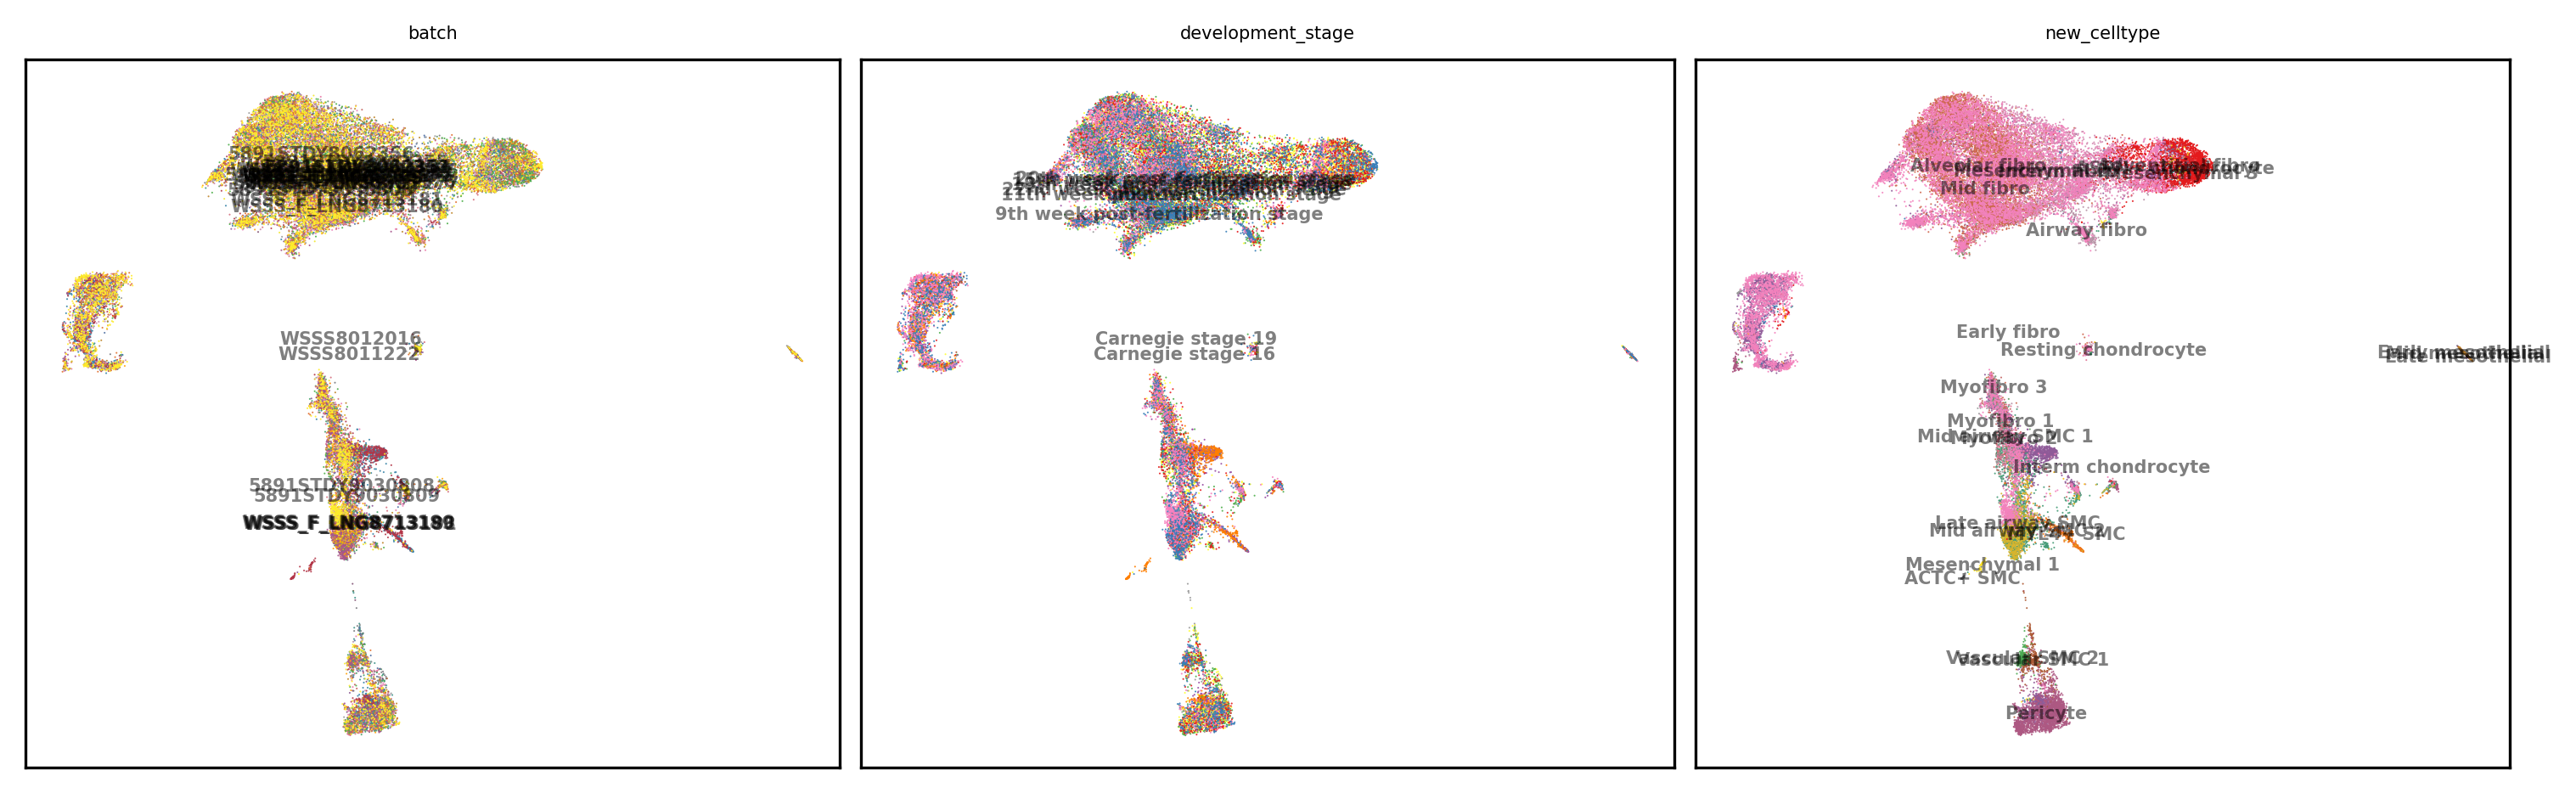

In [101]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=1, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### scVI

In [ ]:
output_key = 'scVI'
with timer:
    scvi_vae = ccd.ul.run_scvi(adata, batch_key=batch_key, output_key=output_key, return_model=True, n_latent=n_comps, return_corrected=False, transform_batch=None)

time_log[output_key] = timer.interval
# Save scVI model
scvi_vae.save(save_dir / f"scvi_model_{file_suffix}.pt")
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/204 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=204` reached.


Concord - INFO - UMAP embedding stored in adata.obsm['scANVI_UMAP']


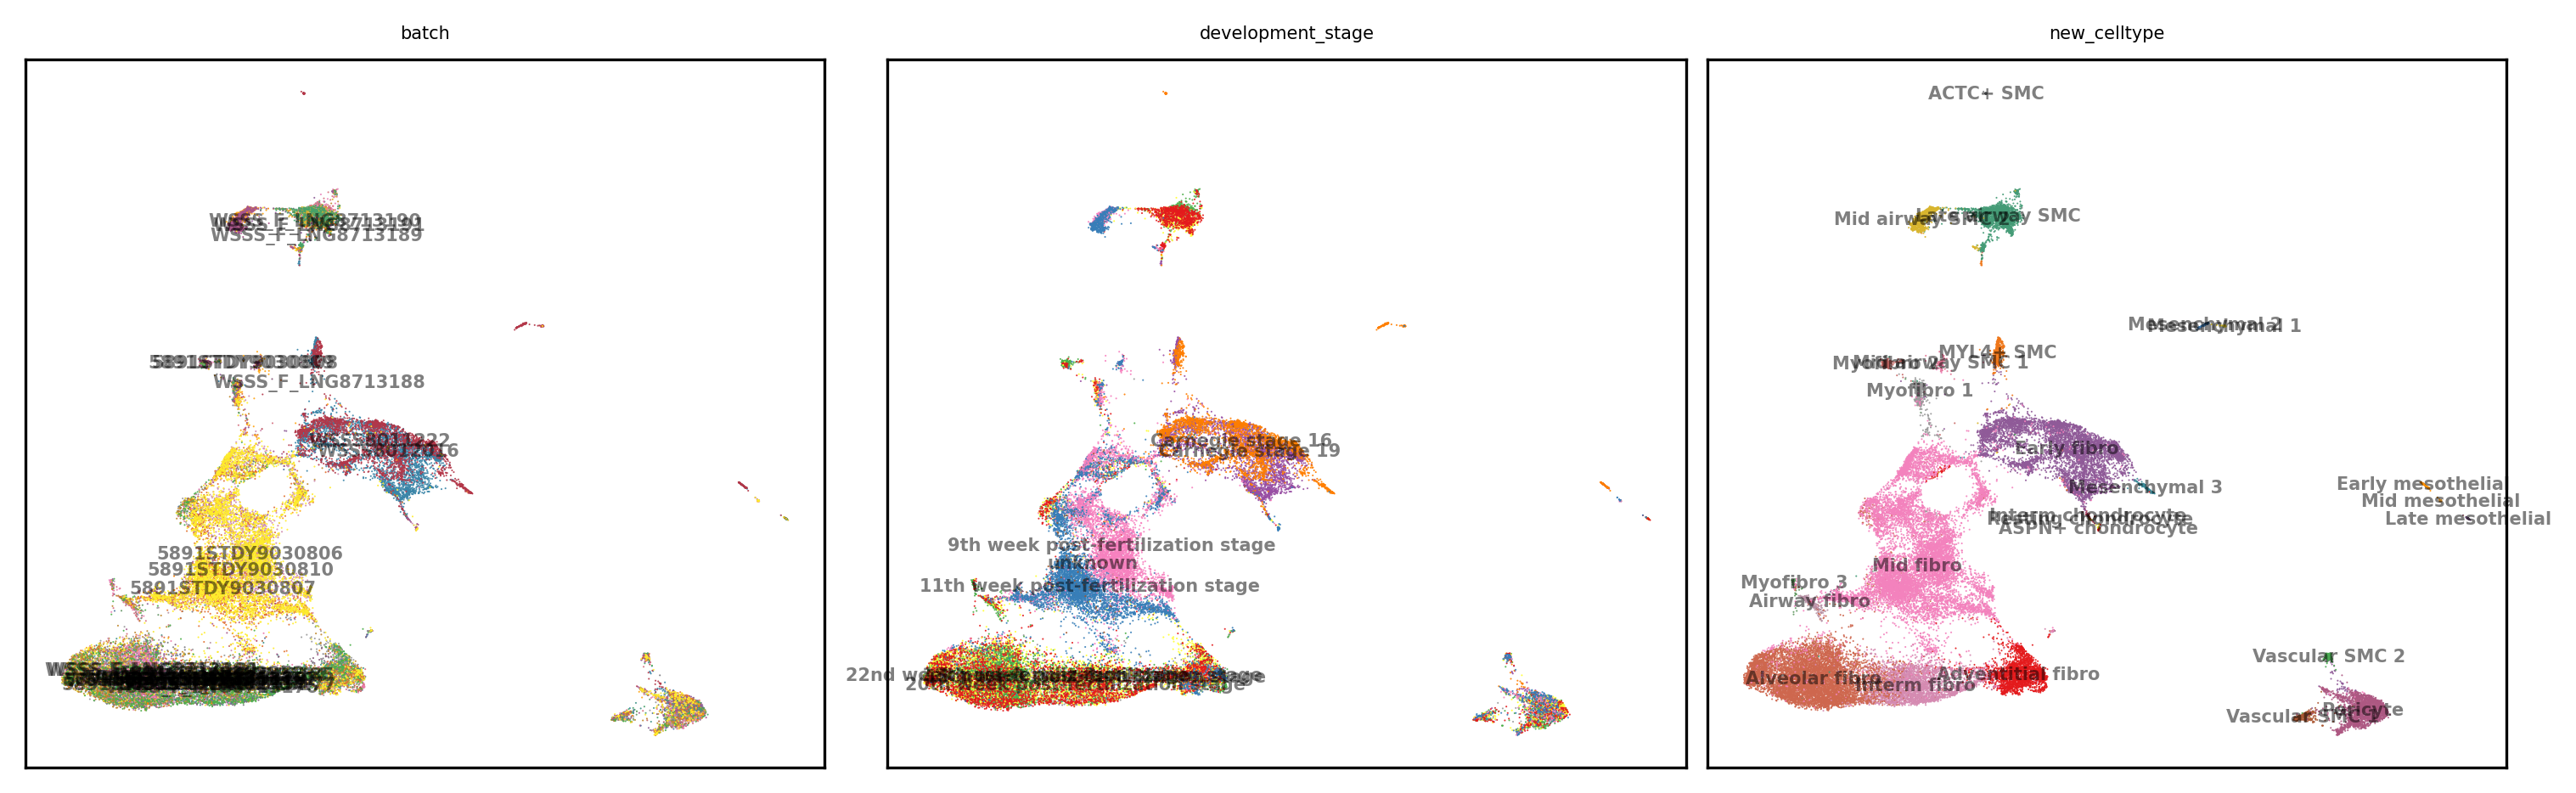

In [99]:

ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=1, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### scANVI

In [96]:
state_key = 'new_celltype'

In [ ]:
output_key = 'scANVI'
with timer:
    ccd.ul.run_scanvi(adata, batch_key=batch_key, labels_key=state_key, output_key=output_key, scvi_model=scvi_vae, return_corrected=False, transform_batch=None)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/20 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Concord - INFO - UMAP embedding stored in adata.obsm['scANVI_UMAP']


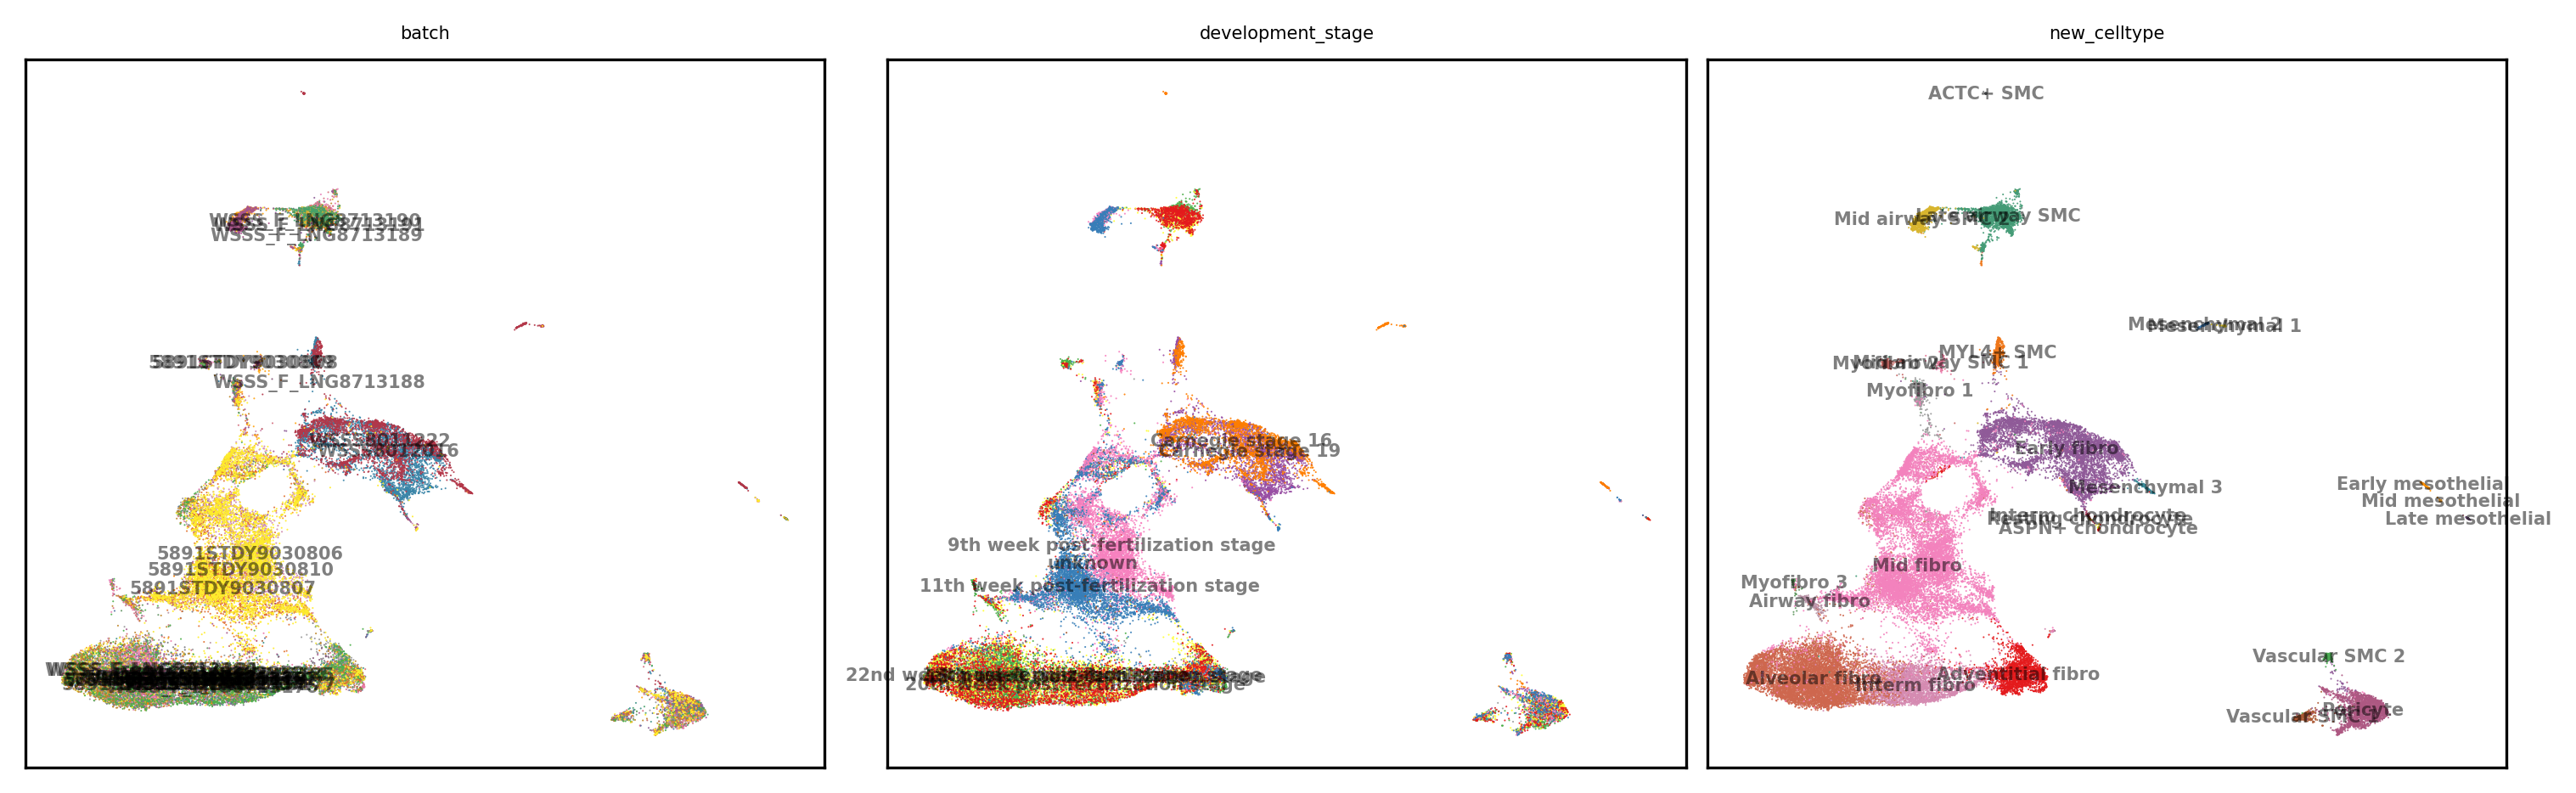

In [104]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=1, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### CONCORD

In [133]:
import importlib
importlib.reload(ccd)
importlib.reload(ccd.ul)

<module 'concord.ul' from '/Users/QZhu/Documents/CONCORD/Concord/src/concord/ul.py'>

In [134]:
output_key = 'Concord'
cur_ccd = ccd.ul.run_concord(adata, layer="X", preprocess=False, batch_key="batch", output_key="Concord", 
                latent_dim = 30, 
                batch_size=64, n_epochs=10, clr_temperature=0.5,
                return_corrected=False, seed=42, device="cpu", save_dir=None)

time_log[output_key] = timer.interval

# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

AttributeError: module 'concord.ul' has no attribute 'run_concord'

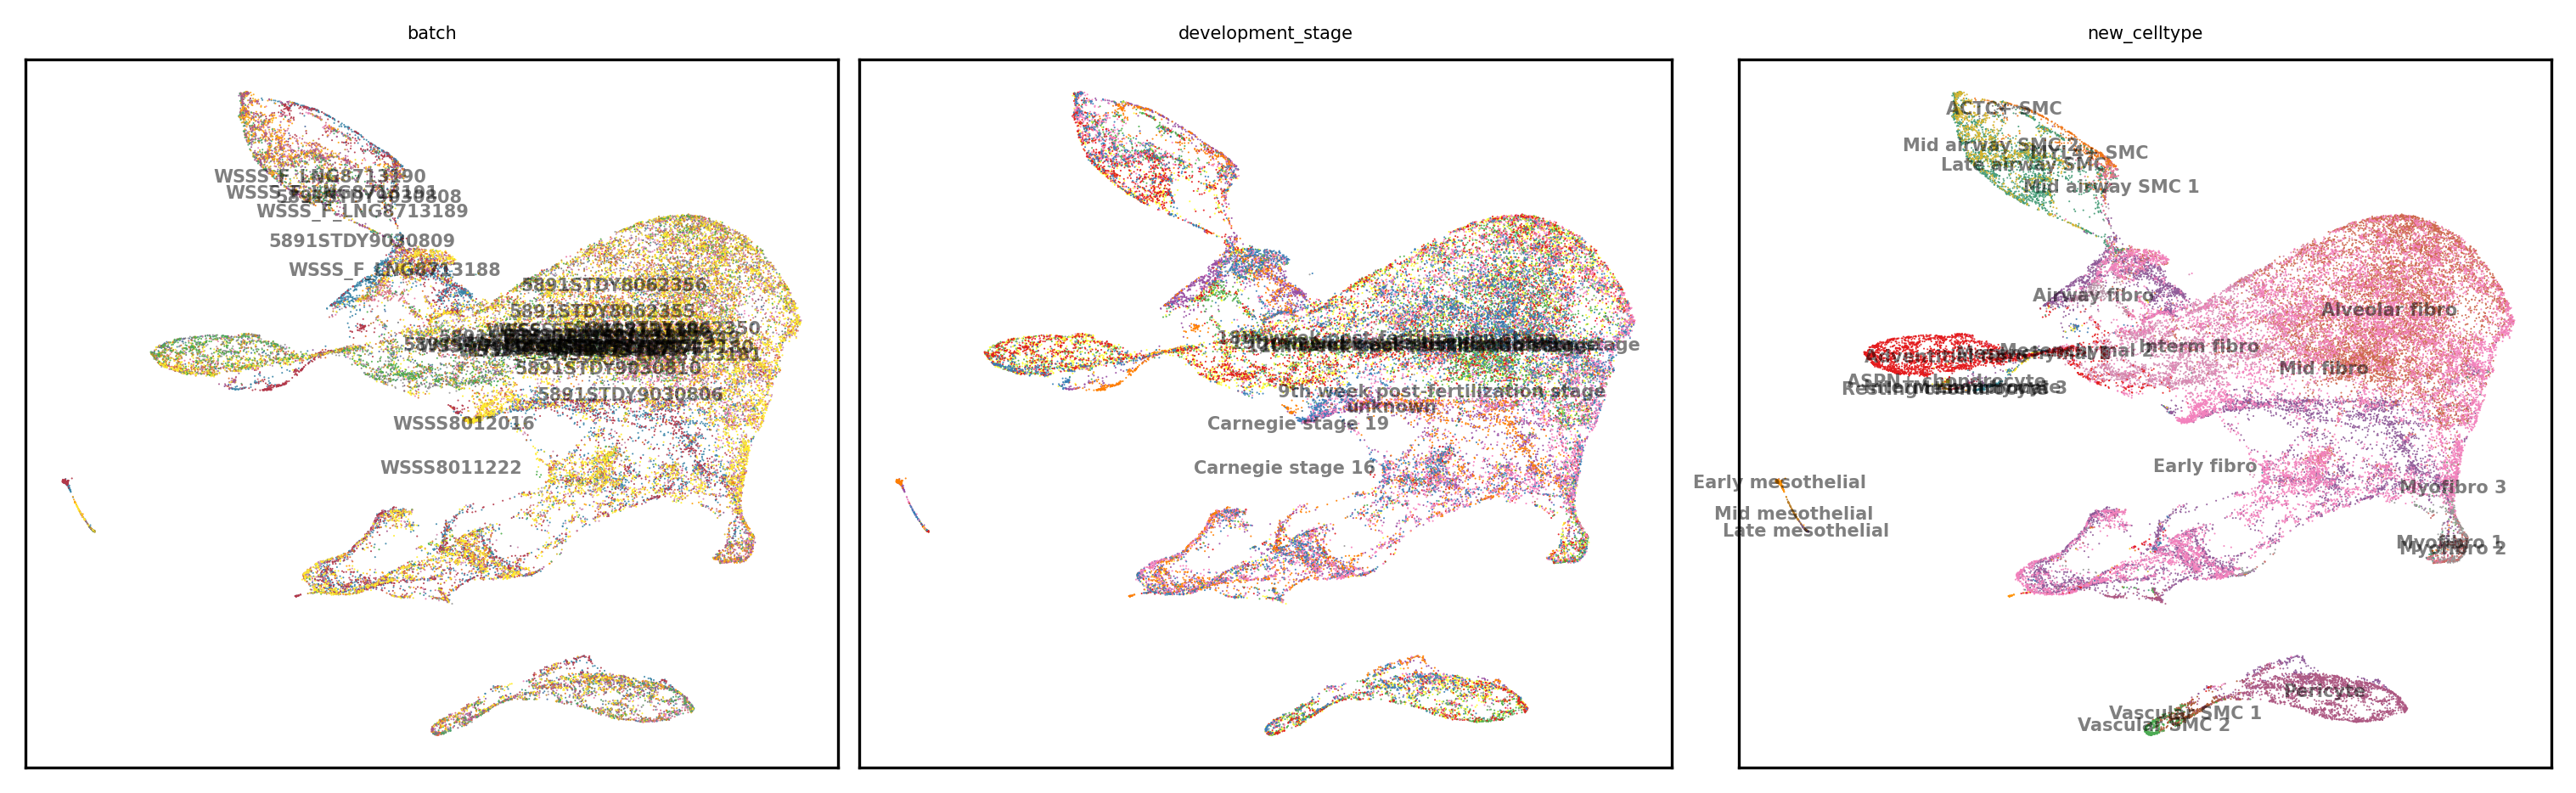

In [135]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=1, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

In [136]:
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad")
print(f"Saved adata to {data_dir / f'adata_{file_suffix}.h5ad'}")

Saved adata to ../data/fetal_lung_fibro/adata_fetal_lung_fibro_scgraph_May30-1349.h5ad


In [118]:
adata.obsm

AxisArrays with keys: X_C0filteredumap, X_C0umap, X_pca, X_umap, Unintegrated, Scanorama, Scanorama_UMAP, Liger, Liger_UMAP, Harmony, Harmony_UMAP, scANVI, scVI, scANVI_UMAP, Concord, Concord_UMAP

## scGraph

In [137]:
# Initialize the graph analyzer
scgraph = scGraph(
    adata_path="../data/fetal_lung_fibro/adata_fetal_lung_fibro_scgraph_May30-1349.h5ad", # Path to AnnData object
    batch_key="batch",                     # Column name for batch information
    label_key="new_celltype",              # Column name for cell type labels
    trim_rate=0.05,                        # Trim rate for robust mean calculation
    thres_batch=100,                       # Minimum number of cells per batch
    thres_celltype=100,                    # Minimum number of cells per cell type
    only_umap=False,                        # Only evaluate 2D embeddings (mostly umaps)
)

# Run the analysis, return a pandas dataframe
results = scgraph.main()

Skipped cell type Myofibro 3, due to < 100 cells
Skipped cell type Mid mesothelial, due to < 100 cells
Skipped cell type Resting chondrocyte, due to < 100 cells
Skipped cell type Interm chondrocyte, due to < 100 cells
Skipped cell type Mesenchymal 2, due to < 100 cells
Skipped cell type Mesenchymal 1, due to < 100 cells
Skipped cell type ACTC+ SMC, due to < 100 cells
Skipped cell type ASPN+ chondrocyte, due to < 100 cells
Processing batches, calcualte centroids and pairwise distances


  0%|          | 0/29 [00:00<?, ?it/s]

Skipped batch 5891STDY8062352, due to < 100 cells


In [138]:
results

Rank-PCA  Corr-PCA  Corr-Weighted
Concord           0.418999  0.679244       0.470362
Concord_UMAP      0.492498  0.685333       0.464028
Harmony           0.836383  0.911761       0.846647
Harmony_UMAP      0.758499  0.798557       0.734238
Liger             0.501255  0.601901       0.423807
Liger_UMAP        0.686597  0.708918       0.666430
Scanorama         0.835138  0.950595       0.847010
Scanorama_UMAP    0.656895  0.742452       0.624716
Unintegrated      0.726143  0.840651       0.687408
X_C0filteredumap  0.549282  0.666778       0.477384
X_C0umap          0.505228  0.675866       0.518819
X_pca             0.839823  0.943126       0.846749
X_umap            0.615549  0.738121       0.604113
scANVI            0.614668  0.852006       0.627479
scANVI_UMAP       0.502802  0.719512       0.598846
scVI              0.613275  0.819508       0.625688